In [1]:
import numpy as np

from matplotlib import pyplot as plot, colors
%matplotlib inline

from mpl_toolkits import basemap
from netCDF4 import Dataset, num2date

In [2]:
# Input file and data visualization settings
file = 'results/gcomc/sst/2022/GS202211_SST_NW_month.nc'
varname = 'sst'
font_size = 20
cmin, cmax = 10, 30
# for CHL we use lognorm
norm = colors.LogNorm(cmin, cmax)
# update the size of figure labels
plot.rcParams.update({'font.size': font_size})

In [3]:
# Assuming these are the coordinates you want to crop to
lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

lat_min_crop, lat_max_crop = 34.5, 35.4
lon_min_crop, lon_max_crop = 138.9, 139.9



In [4]:
# Read the dataset and geo-ref data
with Dataset(file, 'r') as nc:
    sds = nc[varname][:] # the output is a numpy masked array
    sds = np.ma.squeeze(sds)  # Remove singleton dimensions if present
    print("Shape of 'sds' before cropping:", sds.shape)  # Add this line to check the shape

    sds = np.ma.squeeze(sds) # remove singleton dimensions
    label = nc[varname].units.replace('^-3', '$^{-3}$')
    lat = nc['lat'][:]
    lon = nc['lon'][:]
    
    # Find indices for cropping
    lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
    lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]
    # Crop data
        # Now add a check to ensure the indices are within the bounds of the array
    if lat_inds.size > 0 and lon_inds.size > 0:
        # Adjust the slicing based on the actual dimensions of sds
        sds_cropped = sds[lat_inds, :][:, lon_inds]  # This is the updated line for a 2D array
        lat_cropped = lat[lat_inds]
        lon_cropped = lon[lon_inds]
    else:
        print("No data within specified crop bounds.")
    print(np.ma.mean(sds_cropped))    
    # sds_cropped = sds[:, lat_inds, :][:, :, lon_inds]  # Assuming sds has a shape of [time, lat, lon]
    lat_cropped = lat[lat_inds]
    lon_cropped = lon[lon_inds]

    
    time = num2date(nc['time'][:], 
                    units=nc['time'].units,
                    calendar=nc['time'].calendar)
    label = nc[varname].long_name.split(',')[0] + f' [{label}]'

Shape of 'sds' before cropping: (8872, 8993)
23.10021865476339


ValueError: Invalid vmin or vmax

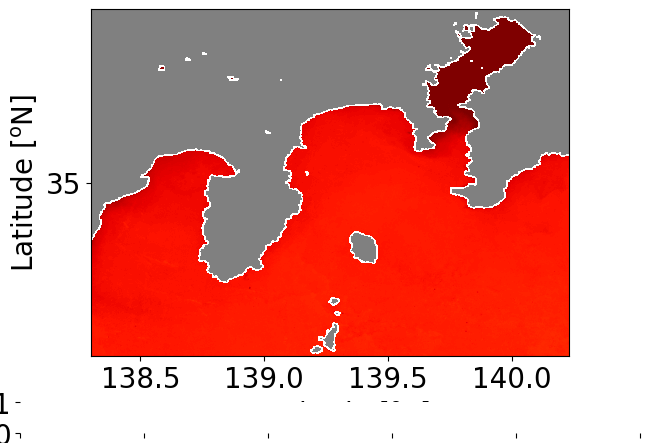

In [5]:
# Visualisation with out basemap
# plot.figure(figsize=(10, 10))
fig, ax = plot.subplots(figsize=(8, 6))  # Adjust the width and height to better suit your data aspect


# figure bounds
extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

# Land mask
mask = np.where(~sds_cropped.mask, np.nan, 0)
plot.imshow(mask, cmap='gray', vmin=-1, vmax=1, extent=extent)

# Data 
# ims = plot.imshow(sds_cropped, cmap='jet', vmin=cmin, vmax=cmax, extent=extent, norm=norm)
ims = plot.imshow(sds_cropped, cmap='jet', extent=extent, norm=norm)

# Figure labels
plot.xlabel('Longitude [$^\mathregular{o}$E]')
plot.ylabel('Latitude [$^\mathregular{o}$N]')
# plot.yticks(range(30, 50, 5))
ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())) + 1, 5))


# Colourbar
cbar = fig.colorbar(ims, orientation='horizontal', aspect=20, pad=0.1, ax=ax, format='%g')
cbar.set_label(label)

# Use tight_layout to automatically adjust subplot params
plot.tight_layout()

# save to file
svf = f'{file[:-3]}.png'
# plot.savefig(svf, dpi=300, bbox_inches='tight')
plot.show()
# close the figure to free memory if you are not showing it
plot.close(fig)

# plot.title(time[0].strftime('%b %Y'))

# # Colourbar
# plot.colorbar(ims, orientation='horizontal', aspect=20, label=label, format='%g')

# # save to file
# svf = f'{file[:-3]}.png'
# # plot.savefig(svf, dpi=300)

# # close
# # plot.close()

In [5]:

from matplotlib.colors import LinearSegmentedColormap

# Convert hex color list to RGB
rgb_colors = [ "green",  "yellow","orange","red"]

runnign
25.195 20.32


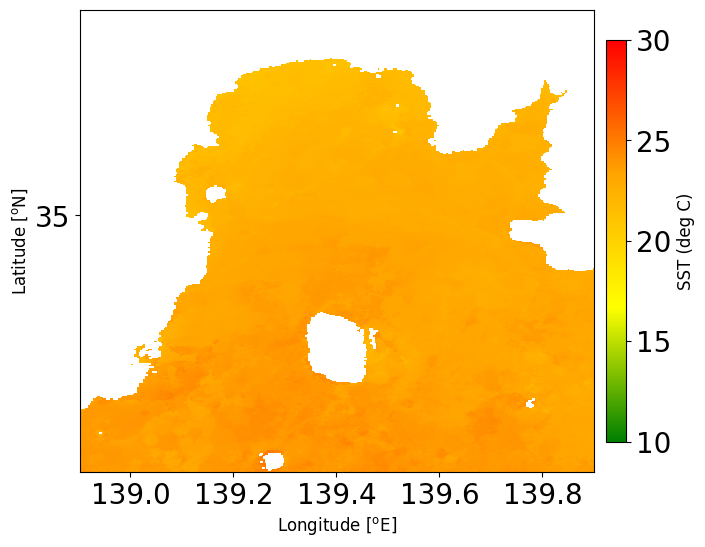

In [6]:
# Visualisation with basemap
print("runnign")
if len(lon_cropped.shape) == 1:
    lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
m = basemap.Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                    urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')


# Visualisation without basemap
# Adjust figsize to change the aspect ratio
fig, ax = plot.subplots(figsize=(8, 6))  # Adjust the width and height to better suit your data aspect ratio

# figure bounds
extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

# Land mask
mask = np.where(~sds_cropped.mask, np.nan, 0)
ax.imshow(mask, cmap='gray', vmin=-2, vmax=0, extent=extent)

# Create a colormap object
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

print(sds_cropped.max(), sds_cropped.min())
# Data 
# We no longer use LogNorm here since we've manually applied log10
# ims = ax.imshow(sds_cropped, cmap='jet', extent=extent)
ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,  cmap=custom_colormap, extent=extent)

# # Figure labels
ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())) + 1, 5))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.02, aspect=20)
# cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")
cbar.set_label('SST (deg C)', fontsize="12")

# # colourbar with axes set to match figure size
# cax = plot.axes([0.8, 0.1, 0.03, 0.7]) # setup colorbar axes
# cb = plot.colorbar(pm, label=label, cax=cax, format='%g') # draw colorbar
# cb.ax.tick_params(width=2, length=4)
# save




start
start


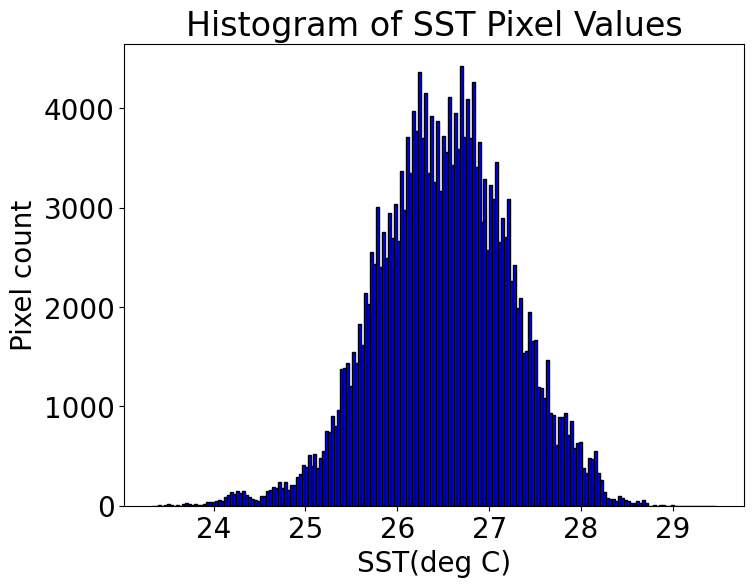

In [23]:
# Assuming sds_cropped contains the log10 transformed data values
# Flatten the array to 1D for histogram plotting
print("start")
pixel_values = sds_cropped.flatten()
pixel_values = pixel_values[~pixel_values.mask]  # Remove masked values (NaN or inf values)

fig, ax = plot.subplots(figsize=(8, 6))
print("start")

# Create the histogram
# You can specify the number of bins or set it to 'auto' for automatic bin selection
n_bins = 'auto'
ax.hist(pixel_values, bins=n_bins, color='blue', edgecolor='black')

# Add labels and title
ax.set_xlabel('SST(deg C)')
ax.set_ylabel('Pixel count')
ax.set_title('Histogram of SST Pixel Values')

# Show the plot
plot.show()


runnign
1.2671717 1.0852906


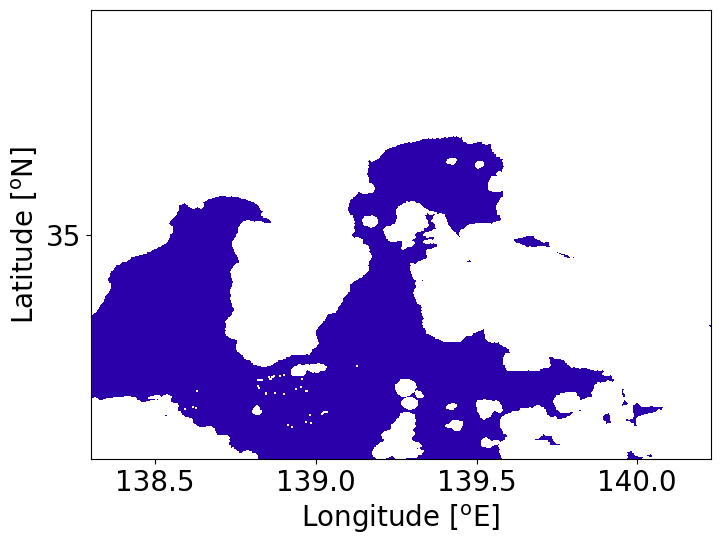

In [11]:
# Visualisation with basemap
print("runnign")
if len(lon_cropped.shape) == 1:
    lon_cropped, lat_cropped = np.meshgrid(lon_cropped, lat_cropped)
lon_0, lat_0 = (lon_cropped.min() + lon_cropped.max()), (lat_cropped.min() + lat_cropped.max()) / 2
m = basemap.Basemap(llcrnrlon=lon_cropped.min(), llcrnrlat=lat_cropped.min(), 
                    urcrnrlon=lon_cropped.max(), urcrnrlat=lat_cropped.max(), resolution='i', 
                    lon_0=lon_0, lat_0=lat_0, projection='merc')

# print(sds_cropped)
sds_cropped = np.ma.masked_less_equal(sds_cropped, 0)  # Mask non-positive values
sds_cropped = np.ma.log10(sds_cropped)  # Apply log10 to the data
# print(sds_cropped)


# Visualisation without basemap
# Adjust figsize to change the aspect ratio
fig, ax = plot.subplots(figsize=(8, 6))  # Adjust the width and height to better suit your data aspect ratio

# figure bounds
extent = [lon_cropped.min(), lon_cropped.max(), lat_cropped.min(), lat_cropped.max()]

# Land mask
mask = np.where(~sds_cropped.mask, np.nan, 0)
ax.imshow(mask, cmap='gray', vmin=-1, vmax=0, extent=extent)

# Create a colormap object
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

print(sds_cropped.max(), sds_cropped.min())
# Data 
# We no longer use LogNorm here since we've manually applied log10
# ims = ax.imshow(sds_cropped, cmap='jet', extent=extent)
ims = ax.imshow(sds_cropped,vmin=cmin, vmax=cmax,  cmap=custom_colormap, extent=extent)

# # Figure labels
ax.set_xlabel('Longitude [$^\mathregular{o}$E]')
ax.set_ylabel('Latitude [$^\mathregular{o}$N]')
ax.set_yticks(range(int(np.ceil(lat_cropped.min())), int(np.ceil(lat_cropped.max())) + 1, 5))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
# cbar = fig.colorbar(ims, orientation='horizontal', aspect=20, pad=0.1, ax=ax)
# cbar.set_label('log10(chl-a) concentration')

# # Use tight_layout to automatically adjust subplot params
# plot.tight_layout()

# # save to file
# svf = f'{file[:-3]}.png'
# plot.savefig(svf, dpi=300, bbox_inches='tight')

# # close the figure to free memory if you are not showing it
# plot.close(fig)

# Remove this if you don't want to display the figure
# plot.show()


# # optional, to change the figure size
# fig = plot.figure(figsize=(10, 10 * m.aspect))
# ax = fig.add_axes([0.08, 0.1, 0.7, 0.7], facecolor='white') 
# print("2")
# mx, my = m(lon_cropped, lat_cropped)
# pm = m.pcolormesh(mx, my, sds_cropped_log, norm=norm, cmap=plot.cm.jet)
# plot.title(time[0].strftime('%b %Y'))

# # Colourbar
# cbar = fig.colorbar(ims, orientation='horizontal', aspect=20, pad=0.1, ax=ax)
# cbar.set_label('log10(chl-a) concentration')

# # colourbar with axes set to match figure size
# cax = plot.axes([0.8, 0.1, 0.03, 0.7]) # setup colorbar axes
# cb = plot.colorbar(pm, label=label, cax=cax, format='%g') # draw colorbar
# cb.ax.tick_params(width=2, length=4)

# plot.sca(ax)  # make the original axes current again
# plot.clim(cmin, cmax)
# print("4")

# m.drawparallels(range(30, 50, 5), labels=[True, False, False, False])
# m.drawmeridians(range(120, 150, 10), labels=[0, 0, 0, 1])
# m.fillcontinents(lake_color='black')  # Fill the continents ',
# m.drawmapboundary(fill_color='black')  # Fill the globe with a blue color
# m.drawcoastlines()
            
# # to visualise
# plot.show()